# A First Comparison of Multiple Explainability Constraints

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from models.mnist_cnn import CNN3b, CNN4b
from loaders.mnist_loader import MNIST_data
from torch.optim import Adam, Adadelta
from losses.losses import FidelityConstraint, StandardCrossEntropy, GradientRegularization, SmoothnessConstraint, GeneralizabilityConstraint
from metrics.metrics import accuracy, MoRF, faithfulness, complexity
from torch.nn import Softmax 
from captum.attr import Saliency, LRP, Occlusion, IntegratedGradients,GradientShap, LayerGradCam, LayerAttribution
from torchsummary import summary
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torch.nn import Linear, ReLU, Sequential, Dropout, Conv2d, MaxPool2d, Module, BatchNorm2d, Flatten
from losses.losses import StandardCrossEntropy
from train import train_xai, train_base
import torchvision
from torch.autograd import Variable
from utils.utils import input_grads, integrated_grads, AddSquareMask, AddGaussianNoise
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import auc
import json
import pandas as pd
import seaborn as sns
import os

In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
outfolder = r".\results\plots"

In [29]:
print("CUDA Available: ",torch.cuda.is_available())
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [5]:
plt.rc("font", size=24)
plt.rc("axes", labelsize=24)
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)
plt.rc("legend", fontsize=22)
plt.rc("lines", markersize=20)
plt.rcParams['axes.grid'] = True

In [6]:
loaders = MNIST_data(batch_size = 60)

In [8]:
bmodel = torch.load(r".\results\final\mnist_cnn_base_9872.pt")
bmodel.eval()
fmodel = torch.load(r".\results\final\mnist_cnn_fidelity_9899.pt")
fmodel.eval()
rmodel = torch.load(r".\results\final\mnist_cnn_gradreg_9852.pt")
rmodel.eval()
lmodel = torch.load(r".\results\final\mnist_cnn_locality_9878.pt")
lmodel.eval()
stmodel = torch.load(r".\results\final\mnist_cnn_smoothness_9855.pt")
stmodel.eval()
symodel = torch.load(r".\results\final\mnist_cnn_symmetry_9854.pt")
symodel.eval()
cmodel = torch.load(r".\results\final\mnist_cnn_consistency_9873.pt")
cmodel.eval()

CNN3b(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=784, out_features=10, bias=True)
)

In [41]:
fid_c1 =  list(bmodel.conv2[0].weight.data.squeeze().detach().cpu().flatten().numpy()) 
fw = pd.DataFrame({"weights": fid_c1 })

base_c1 =  list(fmodel.conv2[0].weight.data.squeeze().detach().cpu().flatten().numpy()) 
bw = pd.DataFrame({"weights": base_c1 })

gradreg_c1 =  list(rmodel.conv2[0].weight.data.squeeze().detach().cpu().flatten().numpy()) 
rw = pd.DataFrame({"weights": gradreg_c1 })


loc_c1 = list(lmodel.conv2[0].weight.data.squeeze().detach().cpu().flatten().numpy()) 
lw = pd.DataFrame({"weights": loc_c1 })

smt_c1 = list(stmodel.conv2[0].weight.data.squeeze().detach().cpu().flatten().numpy()) 
smtw = pd.DataFrame({"weights": smt_c1 })

sym_c1 = list(symodel.conv2[0].weight.data.squeeze().detach().cpu().flatten().numpy()) 
symw = pd.DataFrame({"weights": sym_c1 })

cons_c1 =  list(cmodel.conv2[0].weight.data.squeeze().detach().cpu().flatten().numpy()) 
conw = pd.DataFrame({"weights": cons_c1 })

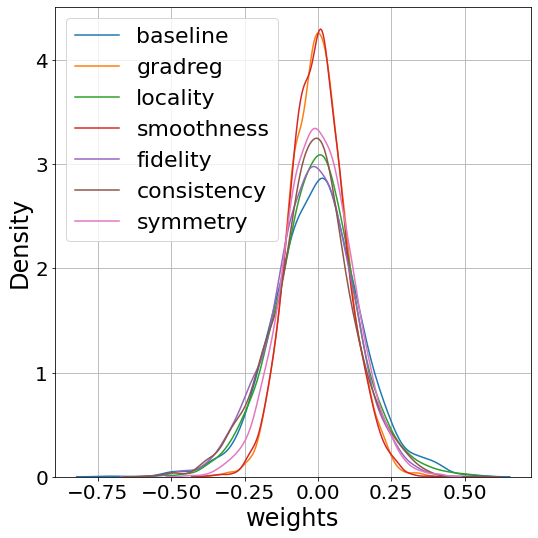

In [42]:
plt.figure(figsize=(8,8))
sns.kdeplot(data=bw, x="weights", label="baseline")
sns.kdeplot(data=rw, x="weights", label="gradreg")
sns.kdeplot(data=lw, x="weights", label="locality")
sns.kdeplot(data=smtw, x="weights", label="smoothness")
sns.kdeplot(data=fw, x="weights", label="fidelity")
sns.kdeplot(data=conw, x="weights", label="consistency")
sns.kdeplot(data=symw, x="weights", label="symmetry")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(outfolder, "weights_distr.png"), bbox_inches="tight", dpi=1100)
plt.show()

# Training Accuracy and Constraints Optimization

In [43]:
fidacc = np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\acc_fidelity.npy")
baseacc = np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\acc_base.npy")
gregacc = np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\acc_gradreg.npy")
locacc = np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\acc_locality.npy")
smootacc = np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\acc_smoothness.npy")
symacc = np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\acc_symmetry.npy")
consacc = np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\acc_consistency.npy")

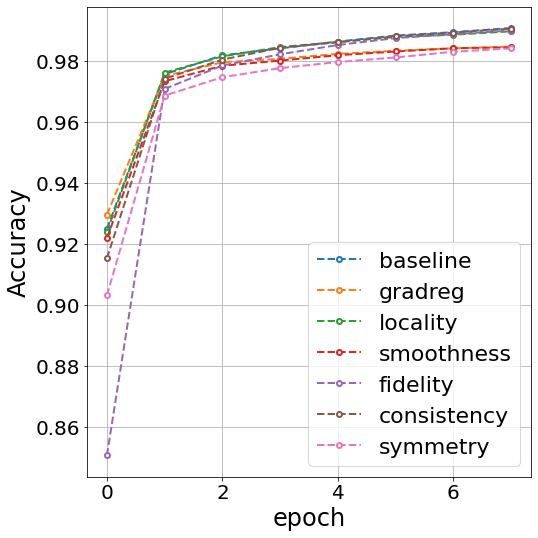

In [44]:
plt.figure(figsize=(8,8))
plt.plot(range(len(fidacc)), baseacc, label="baseline", marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
plt.plot(range(len(gregacc)), gregacc, label="gradreg", marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
plt.plot(range(len(fidacc)), locacc, label="locality", marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
plt.plot(range(len(fidacc)), smootacc, label="smoothness", marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
plt.plot(range(len(fidacc)), fidacc, label="fidelity", marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
plt.plot(range(len(consacc)), consacc, label="consistency", marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
plt.plot(range(len(symacc)), symacc, label="symmetry", marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(outfolder, "all_accuracy.png"), bbox_inches="tight", dpi=1100)
plt.show()
plt.show()

In [45]:
f = open(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\baseline_constraints.json")
data = json.load(f)

In [46]:
data.keys()

dict_keys(['gradreg', 'cons', 'smooth', 'fid', 'loc', 'sym'])

In [47]:
gregcons = np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\xloss_gradreg.npy")
loccons = np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\xloss_locality.npy")
fidcons = np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\xloss_fidelity.npy")
symcons = np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\xloss_symmetry.npy")
smtcons = np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\xloss_smoothness.npy")
concons = np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\xloss_consistency.npy")

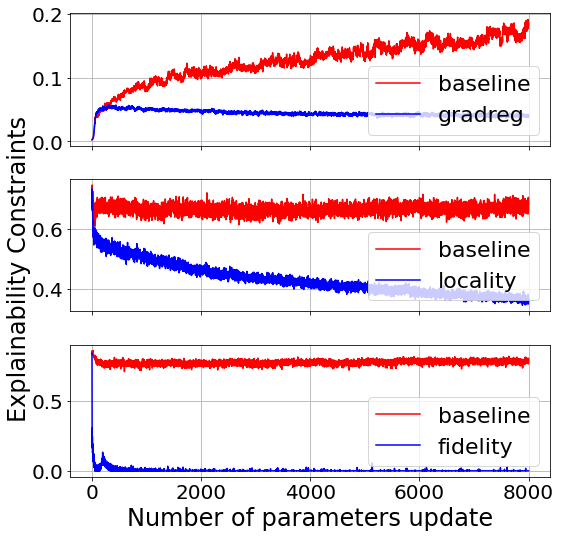

In [52]:
fig, axs = plt.subplots(3, sharex=True, figsize=(8,8))
fig.text(0.003, 0.5, 'Explainability Constraints', va='center', rotation='vertical')
#fig.suptitle('Sharing both axes')
axs[0].plot(range(len(data["gradreg"])), data["gradreg"], label="baseline", color="red")
axs[0].plot(range(len(gregcons)), gregcons, label="gradreg", color="blue")
axs[1].plot(range(len(data["loc"])), data["loc"], label="baseline", color="red")
axs[1].plot(range(len(loccons)), loccons, label="locality", color="blue")
axs[2].plot(range(len(data["fid"])), data["fid"], label="baseline", color="red")
axs[2].plot(range(len(fidcons)), fidcons, label="fidelity", color="blue")
axs[2].set_xlabel("Number of parameters update")
axs[0].legend(loc="lower right")
axs[1].legend(loc="lower right")
axs[2].legend(loc="lower right")
plt.tight_layout()
plt.savefig(os.path.join(outfolder, "losses1.png"), bbox_inches="tight", dpi=1100)
plt.show()

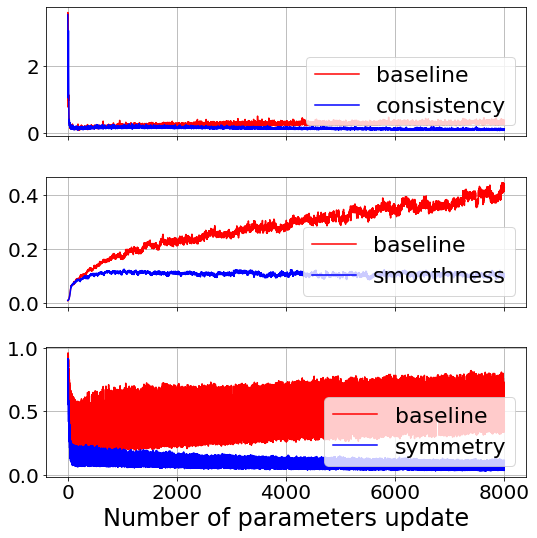

In [51]:
fig, axs = plt.subplots(3, sharex=True, figsize=(8,8))
#fig.text(0.01, 0.5, 'Explainability Constraints', va='center', rotation='vertical')
#fig.suptitle('Sharing both axes')
axs[0].plot(range(len(data["cons"])), data["cons"], label="baseline", color="red")
axs[0].plot(range(len(concons)), concons, label="consistency", color="blue")
axs[1].plot(range(len(data["smooth"])), data["smooth"], label="baseline", color="red")
axs[1].plot(range(len(smtcons)), smtcons, label="smoothness", color="blue")
axs[2].plot(range(len(data['sym'])), 1-np.array(data["sym"]), label="baseline", color="red")
axs[2].plot(range(len(symcons)), symcons, label="symmetry", color="blue")
axs[2].set_xlabel("Number of parameters update")
axs[0].legend(loc="lower right")
axs[1].legend(loc="lower right")
axs[2].legend(loc="lower right")
plt.tight_layout()
plt.savefig(os.path.join(outfolder, "losses2.png"), bbox_inches="tight", dpi=1100)
plt.show()

# Saliency Metrics

## MoRF

### Gradients

In [25]:
perc = list(sorted(np.linspace(0, 100, num=20).astype(int), reverse=True))

In [10]:
bdrop0 = MoRF(bmodel, loaders, perc, method="grad")
rdrop0 = MoRF(rmodel, loaders, perc, method="grad")
cdrop0 = MoRF(cmodel, loaders, perc, method="grad")
sydrop0 = MoRF(symodel, loaders, perc, method="grad")
fdrop0 = MoRF(fmodel, loaders, perc, method="grad")
stdrop0 = MoRF(stmodel, loaders, perc, method="grad")
ldrop0 = MoRF(lmodel, loaders, perc, method="grad")

C:\Users\unknown\Anaconda3\envs\xai4uc3\lib\site-packages\captum\_utils\gradient.py:58: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\metrics\metrics.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  d = softm(model(images.cuda()*maskpos.cuda())).cpu().detach().numpy()[0,torch.argmax(softm(model(images.cuda())))]/torch.max(softm(model(images.cuda()))).cpu().detach().numpy()


In [11]:
print('Baseline Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-bdrop0)))
print('Fidelity Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-fdrop0)))
print('GradReg Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-rdrop0)))
print('Consistency Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-cdrop0)))
print('Symmetry Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-sydrop0)))
print('Smoothness Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-stdrop0)))
print('Locality Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-ldrop0)))

Baseline Model AUC : 0.6960593325195142
Fidelity Model AUC : 0.8267144357058736
GradReg Model AUC : 0.6581631356134522
Consistency Model AUC : 0.6263238189389412
Symmetry Model AUC : 0.8363682176859427
Smoothness Model AUC : 0.6883295440770604
Locality Model AUC : 0.8464486280399096


In [12]:
bdrop1 = MoRF(bmodel, loaders, perc, method="grad",  model_attr=symodel)
rdrop1 = MoRF(rmodel, loaders, perc, method="grad",  model_attr=symodel)
cdrop1 = MoRF(cmodel, loaders, perc, method="grad",  model_attr=symodel)
sydrop1 = MoRF(symodel, loaders, perc, method="grad",  model_attr=symodel)
fdrop1 = MoRF(fmodel, loaders, perc, method="grad",  model_attr=symodel)
stdrop1 = MoRF(stmodel, loaders, perc, method="grad",  model_attr=symodel)
ldrop1 = MoRF(lmodel, loaders, perc, method="grad",  model_attr=symodel)

In [13]:
print('Baseline Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-bdrop1)))
print('Fidelity Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-fdrop1)))
print('GradReg Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-rdrop1)))
print('Consistency Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-cdrop1)))
print('Symmetry Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-sydrop1)))
print('Smoothness Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-stdrop1)))
print('Locality Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-ldrop1)))

Baseline Model AUC : 0.8261769906433445
Fidelity Model AUC : 0.8310213002799826
GradReg Model AUC : 0.8240709079901756
Consistency Model AUC : 0.8263498900792386
Symmetry Model AUC : 0.8363682176859427
Smoothness Model AUC : 0.8263824119527271
Locality Model AUC : 0.8365926310396803


In [19]:
bdrop2 = MoRF(bmodel, loaders, perc, method="grad",  model_attr=bmodel)
rdrop2 = MoRF(rmodel, loaders, perc, method="grad",  model_attr=bmodel)
cdrop2 = MoRF(cmodel, loaders, perc, method="grad",  model_attr=bmodel)
sydrop2 = MoRF(symodel, loaders, perc, method="grad",  model_attr=bmodel)
fdrop2 = MoRF(fmodel, loaders, perc, method="grad",  model_attr=bmodel)
stdrop2 = MoRF(stmodel, loaders, perc, method="grad",  model_attr=bmodel)
ldrop2 = MoRF(lmodel, loaders, perc, method="grad",  model_attr=bmodel)

C:\Users\unknown\Anaconda3\envs\xai4uc3\lib\site-packages\captum\_utils\gradient.py:58: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\metrics\metrics.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  d = softm(model(images.cuda()*maskpos.cuda())).cpu().detach().numpy()[0,torch.argmax(softm(model(images.cuda())))]/torch.max(softm(model(images.cuda()))).cpu().detach().numpy()


In [20]:
print('Baseline Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-bdrop2)))
print('Fidelity Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-fdrop2)))
print('GradReg Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-rdrop2)))
print('Consistency Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-cdrop2)))
print('Symmetry Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-sydrop2)))
print('Smoothness Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-stdrop2)))
print('Locality Model AUC : {}'.format(auc(1-np.array(perc)/100, 1-ldrop2)))

Baseline Model AUC : 0.696059215705632
Fidelity Model AUC : 0.6692288577130922
GradReg Model AUC : 0.5655589044991609
Consistency Model AUC : 0.627573994752486
Symmetry Model AUC : 0.6079314592861131
Smoothness Model AUC : 0.5914111342974039
Locality Model AUC : 0.6801035406375047


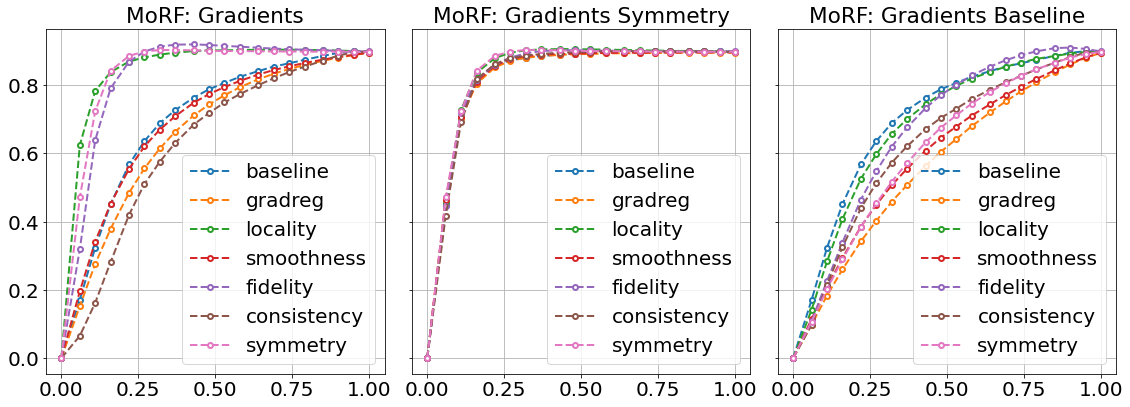

In [23]:
plt.rc("font", size=18)
plt.rc("axes", labelsize=22)
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)
plt.rc("legend", fontsize=20)
plt.rc("lines", markersize=20)

fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(16,6))
axs[0].plot(1-np.array(perc)/100, 1-bdrop0, label="baseline",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[0].plot(1-np.array(perc)/100, 1-rdrop0, label="gradreg",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[0].plot(1-np.array(perc)/100, 1-ldrop0, label="locality",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[0].plot(1-np.array(perc)/100, 1-stdrop0, label="smoothness",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[0].plot(1-np.array(perc)/100, 1-fdrop0, label="fidelity",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[0].plot(1-np.array(perc)/100, 1-cdrop0, label="consistency",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[0].plot(1-np.array(perc)/100, 1-sydrop0, label="symmetry",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[1].plot(1-np.array(perc)/100, 1-bdrop1, label="baseline",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[1].plot(1-np.array(perc)/100, 1-rdrop1, label="gradreg",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[1].plot(1-np.array(perc)/100, 1-ldrop1, label="locality",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[1].plot(1-np.array(perc)/100, 1-stdrop1, label="smoothness",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[1].plot(1-np.array(perc)/100, 1-fdrop1, label="fidelity",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[1].plot(1-np.array(perc)/100, 1-cdrop1, label="consistency",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[1].plot(1-np.array(perc)/100, 1-sydrop1, label="symmetry",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[2].plot(1-np.array(perc)/100, 1-bdrop2, label="baseline",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[2].plot(1-np.array(perc)/100, 1-rdrop2, label="gradreg",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[2].plot(1-np.array(perc)/100, 1-ldrop2, label="locality",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[2].plot(1-np.array(perc)/100, 1-stdrop2, label="smoothness",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[2].plot(1-np.array(perc)/100, 1-fdrop2, label="fidelity",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[2].plot(1-np.array(perc)/100, 1-cdrop2, label="consistency",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[2].plot(1-np.array(perc)/100, 1-sydrop2, label="symmetry",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[0].set_title("MoRF: Gradients")
axs[0].legend(loc="lower right")
axs[1].set_title("MoRF: Gradients Symmetry")
axs[1].legend(loc="lower right")
axs[2].set_title("MoRF: Gradients Baseline")
axs[2].legend(loc="lower right")
#axs[2].legend(loc="lower right")
plt.tight_layout()
plt.savefig(os.path.join(outfolder, "morf_grad.png"), bbox_inches="tight", dpi=1100)
plt.show()


#plt.title("MoRF: Gradients")
#plt.plot(1-np.array(perc)/100, 1-bdrop, label="baseline",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
#plt.plot(1-np.array(perc)/100, 1-rdrop, label="gradreg",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
#plt.plot(1-np.array(perc)/100, 1-ldrop, label="locality",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
#plt.plot(1-np.array(perc)/100, 1-stdrop, label="smoothness",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
#plt.plot(1-np.array(perc)/100, 1-fdrop, label="fidelity",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
#plt.plot(1-np.array(perc)/100, 1-cdrop, label="consistency",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
#plt.plot(1-np.array(perc)/100, 1-sydrop, label="symmetry",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
#plt.xlabel("% features removed")
#plt.ylabel("Avg error")
#plt.grid(True)
#plt.legend()
#plt.savefig(os.path.join(outfolder, "morf_grad.png"), bbox_inches="tight", dpi=1100)
#plt.show()

## Faithfulness

In [27]:
bfaith = faithfulness(bmodel, loaders, perc)
cfaith = faithfulness(cmodel, loaders, perc)
ffaith = faithfulness(fmodel, loaders, perc)
lfaith = faithfulness(lmodel, loaders, perc)
syfaith = faithfulness(symodel, loaders, perc)
stfaith = faithfulness(stmodel, loaders, perc)
rfaith = faithfulness(rmodel, loaders, perc)

In [10]:
print('Baseline faithfulness : {}'.format(np.mean(bfaith)))
print('Fidelity faithfulness: {}'.format(np.mean(ffaith)))
print('GradReg faithfulness : {}'.format(np.mean(rfaith)))
print('Consistency faithfulness : {}'.format(np.mean(cfaith)))
print('Symmetry faithfulness : {}'.format(np.mean(syfaith)))
print('Smoothness faithfulness : {}'.format(np.mean(stfaith)))
print('Locality faithfulness : {}'.format(np.mean(lfaith)))

Baseline faithfulness : 0.8008615281357718
Fidelity faithfulness: 0.797446508528459
GradReg faithfulness : 0.909518790644374
Consistency faithfulness : 0.8224188734807852
Symmetry faithfulness : 0.8197843838408855
Smoothness faithfulness : 0.8943684975149523
Locality faithfulness : 0.7072774143737556


## Complexity

In [55]:
bcomp = complexity(bmodel, loaders)
ccomp = complexity(cmodel, loaders)
sycomp = complexity(symodel, loaders)
stcomp = complexity(stmodel, loaders)
fcomp = complexity(fmodel, loaders)
lcomp = complexity(lmodel, loaders)
rcomp = complexity(rmodel, loaders)

In [56]:
print('Baseline complexity : {}'.format(bcomp))
print('Fidelity complexity : {}'.format(fcomp))
print('GradReg complexity : {}'.format(rcomp))
print('Consistency complexity : {}'.format(ccomp))
print('Symmetry complexity : {}'.format(sycomp))
print('Smoothness complexity : {}'.format(stcomp))
print('Locality complexity : {}'.format(lcomp))

Baseline complexity : 4.399892330169678
Fidelity complexity : 4.304908752441406
GradReg complexity : 4.327702522277832
Consistency complexity : 4.376689910888672
Symmetry complexity : 4.229517936706543
Smoothness complexity : 4.329282760620117
Locality complexity : 4.347668647766113


## ROAR and robustness under perturbations 


In [8]:
perc = [0, 0.2, 0.5, 0.8, 0.9]
std = [0, 0.1, 0.5, 1.0, 1.5]
max_size = [0, 6, 8, 10, 12]

In [9]:
broar = np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\roar_base.npy")
froar = np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\roar_fidelity.npy")
rroar = np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\roar_gradreg.npy")
lroar = np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\roar_locality.npy")
stroar = np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\roar_smoothness.npy")
syroar = np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\roar_symmetry.npy")
croar =  np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\roar_consistency.npy")

In [9]:
bblock = np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\block_baseline.npy")
fblock = np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\block_fidelity.npy")
rblock = np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\block_gradreg.npy")
lblock = np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\block_locality.npy")
stblock = np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\block_smoothness.npy")
syblock = np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\block_symmetry.npy")
cblock =  np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\block_consistency.npy")

In [10]:
bgauss = np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\gauss_baseline.npy")
fgauss = np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\gauss_fidelity.npy")
rgauss = np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\gauss_gradreg.npy")
lgauss = np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\gauss_locality.npy")
stgauss = np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\gauss_smoothness.npy")
sygauss = np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\gauss_symmetry.npy")
cgauss =  np.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\final\gauss_consistency.npy")

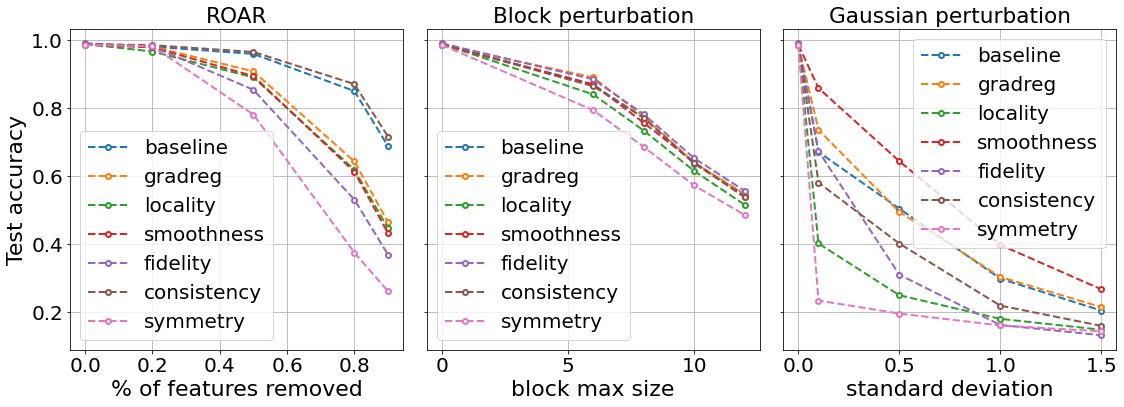

In [15]:
plt.rc("font", size=18)
plt.rc("axes", labelsize=22)
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)
plt.rc("legend", fontsize=20)
plt.rc("lines", markersize=20)

fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(16,6))
axs[0].plot(perc, broar, label="baseline",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[0].plot(perc, rroar, label="gradreg",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[0].plot(perc, lroar, label="locality",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[0].plot(perc, stroar, label="smoothness",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[0].plot(perc, froar, label="fidelity",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[0].plot(perc, croar, label="consistency",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[0].plot(perc, syroar, label="symmetry",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[1].plot(max_size, bblock, label="baseline",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[1].plot(max_size, rblock, label="gradreg",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[1].plot(max_size, lblock, label="locality",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[1].plot(max_size, stblock, label="smoothness",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[1].plot(max_size, fblock, label="fidelity",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[1].plot(max_size, cblock, label="consistency",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[1].plot(max_size, syblock, label="symmetry",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[2].plot(std, bgauss, label="baseline",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[2].plot(std, rgauss, label="gradreg",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[2].plot(std, lgauss, label="locality",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[2].plot(std, stgauss, label="smoothness",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[2].plot(std, fgauss, label="fidelity",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[2].plot(std, cgauss, label="consistency",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[2].plot(std, sygauss, label="symmetry",  marker='o', ms=5, mfc='w', mew=2, lw=2, ls='--')
axs[0].set_title("ROAR")
axs[0].legend(loc="lower left")
axs[0].set_xlabel("% of features removed")
axs[0].set_ylabel("Test accuracy")
axs[1].set_title("Block perturbation")
axs[1].legend(loc="lower left")
axs[1].set_xlabel("block max size")
axs[2].set_title("Gaussian perturbation")
axs[2].legend(loc="upper right")
axs[2].set_xlabel("standard deviation")
#axs[2].legend(loc="lower right")
plt.tight_layout()
plt.savefig(os.path.join(outfolder, "roar_pert.png"), bbox_inches="tight", dpi=1100)
plt.show()


In [23]:
print('Baseline Model ROAR : {}'.format(auc(perc, broar)))
print('Fidelity Model ROAR : {}'.format(auc(perc, froar)))
print('GradReg Model ROAR : {}'.format(auc(perc, rroar)))
print('Smoothness Model ROAR : {}'.format(auc(perc, stroar)))
print('Locality Model ROAR : {}'.format(auc(perc, lroar)))
print('Symmetry Model ROAR : {}'.format(auc(perc, syroar)))
print('Consistency Model ROAR : {}'.format(auc(perc, croar)))


Baseline Model ROAR : 0.8355049999999999
Fidelity Model ROAR : 0.7244
GradReg Model ROAR : 0.7674100000000001
Smoothness Model ROAR : 0.755015
Locality Model ROAR : 0.75294
Symmetry Model ROAR : 0.6657299999999999
Consistency Model ROAR : 0.84387


In [11]:
print('Baseline Model Gauss : {}'.format(auc(std, bgauss)))
print('Fidelity Model Gauss : {}'.format(auc(std, fgauss)))
print('GradReg Model Gauss : {}'.format(auc(std, rgauss)))
print('Smoothness Model Gauss : {}'.format(auc(std, stgauss)))
print('Locality Model Gauss : {}'.format(auc(std, lgauss)))
print('Symmetry Model Gauss : {}'.format(auc(std, sygauss)))
print('Consistency Model Gauss : {}'.format(auc(std, cgauss)))


Baseline Model Gauss : 0.6431300000000001
Fidelity Model Gauss : 0.47013499999999997
GradReg Model Gauss : 0.6602299999999999
Smoothness Model Gauss : 0.8181200000000002
Locality Model Gauss : 0.388
Symmetry Model Gauss : 0.310655
Consistency Model Gauss : 0.5234


In [12]:
print('Baseline Model Block : {}'.format(auc(max_size, bblock)))
print('Fidelity Model Block : {}'.format(auc(max_size, fblock)))
print('GradReg Model Block : {}'.format(auc(max_size, rblock)))
print('Smoothness Model Block : {}'.format(auc(max_size, stblock)))
print('Locality Model Block : {}'.format(auc(max_size, lblock)))
print('Symmetry Model Block : {}'.format(auc(max_size, syblock)))
print('Consistency Model Block : {}'.format(auc(max_size, cblock)))


Baseline Model Block : 9.788
Fidelity Model Block : 9.9278
GradReg Model Block : 9.886899999999999
Smoothness Model Block : 9.7637
Locality Model Block : 9.531400000000001
Symmetry Model Block : 9.1271
Consistency Model Block : 9.7714


## Visual Comparison of Improved Saliency Maps

In [10]:
bgrad = Saliency(bmodel)
rgrad = Saliency(rmodel)
lgrad = Saliency(lmodel)
stgrad = Saliency(stmodel)
fgrad = Saliency(fmodel)
cgrad = Saliency(cmodel)
sygrad = Saliency(symodel)

In [ ]:
sample = iter(loaders['test'])
imgs = []
lbls = []


for i in range(120):
    img, lbl = next(sample)
    img = img.to(device)
    lbl = lbl.to(device)
    imgs.append(img)
    lbls.append(lbl)

In [59]:
i1 = 57 
i2 = 103
i3 = 20
i4 = 21

In [60]:
battr0 = bgrad.attribute(imgs[i1], target=lbls[i1].item())
battr0 = battr0.squeeze()
rattr0 = rgrad.attribute(imgs[i1], target=lbls[i1].item())
rattr0 = rattr0.squeeze()
lattr0 = lgrad.attribute(imgs[i1], target=lbls[i1].item())
lattr0 = lattr0.squeeze()
stattr0 = stgrad.attribute(imgs[i1], target=lbls[i1].item())
stattr0 = stattr0.squeeze()
fattr0 = fgrad.attribute(imgs[i1], target=lbls[i1].item())
fattr0 = fattr0.squeeze()
cattr0 = cgrad.attribute(imgs[i1], target=lbls[i1].item())
cattr0 = cattr0.squeeze()
syattr0 = sygrad.attribute(imgs[i1], target=lbls[i1].item())
syattr0 = syattr0.squeeze()

battr1 = bgrad.attribute(imgs[i2], target=lbls[i2].item())
battr1 = battr1.squeeze()
rattr1 = rgrad.attribute(imgs[i2], target=lbls[i2].item())
rattr1 = rattr1.squeeze()
lattr1 = lgrad.attribute(imgs[i2], target=lbls[i2].item())
lattr1 = lattr1.squeeze()
stattr1 = stgrad.attribute(imgs[i2], target=lbls[i2].item())
stattr1 = stattr1.squeeze()
fattr1 = fgrad.attribute(imgs[i2], target=lbls[i2].item())
fattr1 = fattr1.squeeze()
cattr1 = cgrad.attribute(imgs[i2], target=lbls[i2].item())
cattr1 = cattr1.squeeze()
syattr1 = sygrad.attribute(imgs[i2], target=lbls[i2].item())
syattr1 = syattr1.squeeze()

battr2 = bgrad.attribute(imgs[i3], target=lbls[i3].item())
battr2 = battr2.squeeze()
rattr2 = rgrad.attribute(imgs[i3], target=lbls[i3].item())
rattr2 = rattr2.squeeze()
lattr2 = lgrad.attribute(imgs[i3], target=lbls[i3].item())
lattr2 = lattr2.squeeze()
stattr2 = stgrad.attribute(imgs[i3], target=lbls[i3].item())
stattr2 = stattr2.squeeze()
fattr2 = fgrad.attribute(imgs[i3], target=lbls[i3].item())
fattr2 = fattr2.squeeze()
cattr2 = cgrad.attribute(imgs[i3], target=lbls[i3].item())
cattr2 = cattr2.squeeze()
syattr2 = sygrad.attribute(imgs[i3], target=lbls[i3].item())
syattr2 = syattr2.squeeze()

battr3 = bgrad.attribute(imgs[i4], target=lbls[i4].item())
battr3 = battr3.squeeze()
rattr3 = rgrad.attribute(imgs[i4], target=lbls[i4].item())
rattr3 = rattr3.squeeze()
lattr3 = lgrad.attribute(imgs[i4], target=lbls[i4].item())
lattr3 = lattr3.squeeze()
stattr3 = stgrad.attribute(imgs[i4], target=lbls[i4].item())
stattr3 = stattr3.squeeze()
fattr3 = fgrad.attribute(imgs[i4], target=lbls[i4].item())
fattr3 = fattr3.squeeze()
cattr3 = cgrad.attribute(imgs[i4], target=lbls[i4].item())
cattr3 = cattr3.squeeze()
syattr3 = sygrad.attribute(imgs[i4], target=lbls[i4].item())
syattr3 = syattr3.squeeze()

C:\Users\unknown\Anaconda3\envs\xai4uc3\lib\site-packages\captum\_utils\gradient.py:58: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


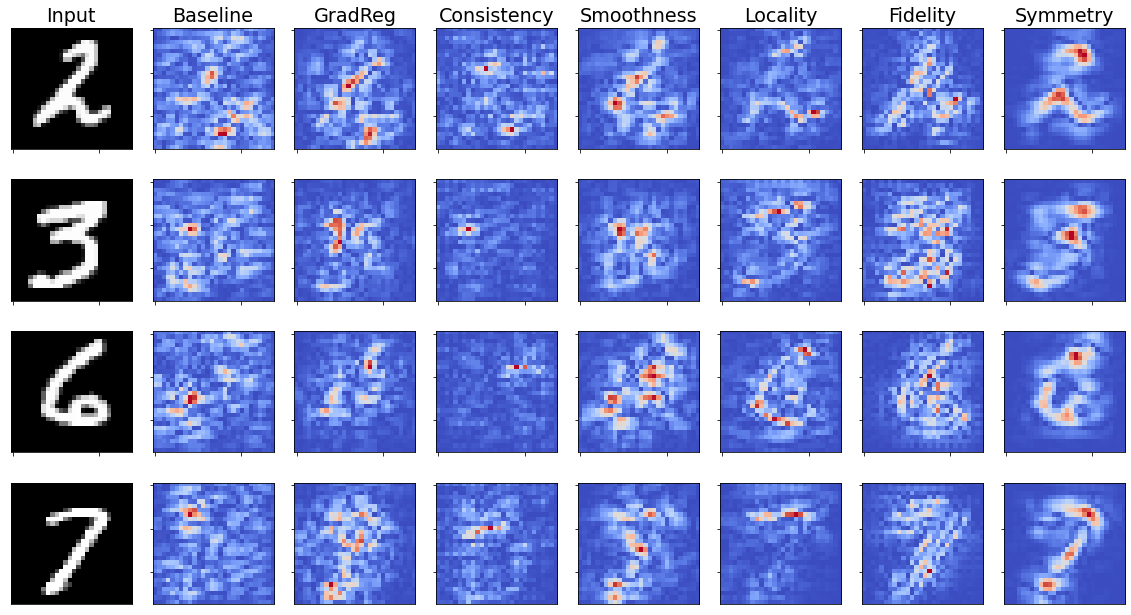

In [61]:
plt.rc("font", size=16)

fig, axs = plt.subplots(nrows=4, ncols=8, sharey = True, sharex=True, figsize=(16,9), gridspec_kw={'height_ratios': [1, 1, 1, 1]})
#fig.text(0.003, 0.5, 'Explainability Constraints', va='center', rotation='vertical')
#fig.suptitle('Sharing both axes')
axs[0,0].imshow(imgs[i1].squeeze().cpu().numpy(), cmap="gray")
axs[0,1].imshow(battr0.cpu().numpy(), cmap="coolwarm")
axs[0,2].imshow(rattr0.cpu().numpy(), cmap="coolwarm")
axs[0,3].imshow(cattr0.cpu().numpy(), cmap="coolwarm")
axs[0,4].imshow(stattr0.cpu().numpy(), cmap="coolwarm")
axs[0,5].imshow(lattr0.cpu().numpy(), cmap="coolwarm")
axs[0,6].imshow(fattr0.cpu().numpy(), cmap="coolwarm")
axs[0,7].imshow(syattr0.cpu().numpy(), cmap="coolwarm")
axs[1,0].imshow(imgs[i2].squeeze().cpu().numpy(), cmap="gray")
axs[1,1].imshow(battr1.cpu().numpy(), cmap="coolwarm")
axs[1,2].imshow(rattr1.cpu().numpy(), cmap="coolwarm")
axs[1,3].imshow(cattr1.cpu().numpy(), cmap="coolwarm")
axs[1,4].imshow(stattr1.cpu().numpy(), cmap="coolwarm")
axs[1,5].imshow(lattr1.cpu().numpy(), cmap="coolwarm")
axs[1,6].imshow(fattr1.cpu().numpy(), cmap="coolwarm")
axs[1,7].imshow(syattr1.cpu().numpy(), cmap="coolwarm")
axs[2,0].imshow(imgs[i3].squeeze().cpu().numpy(), cmap="gray")
axs[2,1].imshow(battr2.cpu().numpy(), cmap="coolwarm")
axs[2,2].imshow(rattr2.cpu().numpy(), cmap="coolwarm")
axs[2,3].imshow(cattr2.cpu().numpy(), cmap="coolwarm")
axs[2,4].imshow(stattr2.cpu().numpy(), cmap="coolwarm")
axs[2,5].imshow(lattr2.cpu().numpy(), cmap="coolwarm")
axs[2,6].imshow(fattr2.cpu().numpy(), cmap="coolwarm")
axs[2,7].imshow(syattr2.cpu().numpy(), cmap="coolwarm")
axs[3, 0].imshow(imgs[i4].squeeze().cpu().numpy(), cmap="gray")
axs[3,1].imshow(battr3.cpu().numpy(), cmap="coolwarm")
axs[3,2].imshow(rattr3.cpu().numpy(), cmap="coolwarm")
axs[3,3].imshow(cattr3.cpu().numpy(), cmap="coolwarm")
axs[3,4].imshow(stattr3.cpu().numpy(), cmap="coolwarm")
axs[3,5].imshow(lattr3.cpu().numpy(), cmap="coolwarm")
axs[3,6].imshow(fattr3.cpu().numpy(), cmap="coolwarm")
axs[3,7].imshow(syattr3.cpu().numpy(), cmap="coolwarm")
axs[0,0].title.set_text('Input')
axs[0,1].title.set_text('Baseline')
axs[0,2].title.set_text('GradReg')
axs[0,3].title.set_text('Consistency')
axs[0,4].title.set_text('Smoothness')
axs[0,5].title.set_text('Locality')
axs[0,6].title.set_text('Fidelity')
axs[0,7].title.set_text('Symmetry')

axs[3,0].axes.xaxis.set_visible(False)
axs[3,1].axes.xaxis.set_visible(False)
axs[3,2].axes.xaxis.set_visible(False)
axs[3,3].axes.xaxis.set_visible(False)
axs[3,4].axes.xaxis.set_visible(False)
axs[3,5].axes.xaxis.set_visible(False)
axs[3,6].axes.xaxis.set_visible(False)
axs[3,7].axes.xaxis.set_visible(False)
axs[0,0].axes.yaxis.set_visible(False)
axs[1,0].axes.yaxis.set_visible(False)
axs[2,0].axes.yaxis.set_visible(False)
axs[3,0].axes.yaxis.set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(outfolder, "saliency_mnist1.pdf"), bbox_inches="tight", dpi=1100)
plt.show()

## Fashion MNIST

In [30]:
train_data = datasets.FashionMNIST(root = 'data', download=True, train=True, transform=ToTensor())
test_data = datasets.FashionMNIST(root = 'data', download=True, train=False, transform=ToTensor())


In [31]:
batch_size=60

In [32]:
loaders = {
        'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=1),
    
        'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=1, 
                                          shuffle=True, 
                                          num_workers=1),
    }

In [60]:
class CNN4b(Module):   
    def __init__(self):
        super(CNN4b, self).__init__()

        self.conv1 = Sequential(
            Conv2d(1, 32, kernel_size=3, stride=1, padding=2),
            BatchNorm2d(32),
            ReLU(inplace=True),
        )
        
        self.conv2 = Sequential(
            Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
            BatchNorm2d(64),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Flatten()
        )
        
        self.drop1 = Dropout(0.15)
        
        self.dense1 = Sequential(
            Linear(16384,32)
        )
        
        self.drop2 = Dropout(0.25)
        
        self.dense2 = Sequential(
            Linear(32, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.drop1(x)
        x = self.dense1(x)
        x = self.drop2(x)
        x = self.dense2(x)
        return x

In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN4b().to(device)
summary(model.to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             320
       BatchNorm2d-2           [-1, 32, 30, 30]              64
              ReLU-3           [-1, 32, 30, 30]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
           Flatten-8                [-1, 16384]               0
           Dropout-9                [-1, 16384]               0
           Linear-10                   [-1, 32]         524,320
          Dropout-11                   [-1, 32]               0
           Linear-12                   [-1, 10]             330
Total params: 543,658
Trainable params: 543,658
Non-trainable params: 0
-------------------------------

In [62]:
criterion = StandardCrossEntropy()
optimizer = Adam(model.parameters(), lr=0.001)  
acc, loss  = train_nn(model, loaders, 8, optimizer, penalty="base")

Epoch [1/8], Step [100/1000], Loss: 0.5855
Epoch [1/8], Step [200/1000], Loss: 0.5837
Epoch [1/8], Step [300/1000], Loss: 0.6320
Epoch [1/8], Step [400/1000], Loss: 0.4730
Epoch [1/8], Step [500/1000], Loss: 0.2555
Epoch [1/8], Step [600/1000], Loss: 0.2453
Epoch [1/8], Step [700/1000], Loss: 0.2574
Epoch [1/8], Step [800/1000], Loss: 0.2274
Epoch [1/8], Step [900/1000], Loss: 0.3163
Epoch [1/8], Step [1000/1000], Loss: 0.3398
Accuracy =  0.8413
Epoch [2/8], Step [100/1000], Loss: 0.1566
Epoch [2/8], Step [200/1000], Loss: 0.3615
Epoch [2/8], Step [300/1000], Loss: 0.2535
Epoch [2/8], Step [400/1000], Loss: 0.3367
Epoch [2/8], Step [500/1000], Loss: 0.3048
Epoch [2/8], Step [600/1000], Loss: 0.4171
Epoch [2/8], Step [700/1000], Loss: 0.3847
Epoch [2/8], Step [800/1000], Loss: 0.4222
Epoch [2/8], Step [900/1000], Loss: 0.3264
Epoch [2/8], Step [1000/1000], Loss: 0.3623
Accuracy =  0.8969666666666667
Epoch [3/8], Step [100/1000], Loss: 0.2037
Epoch [3/8], Step [200/1000], Loss: 0.3022
Ep

In [63]:
test_acc = accuracy(model,loaders)

In [64]:
test_acc

0.9235

In [65]:
torch.save(model,os.path.join(r".\results\final","fashion_cnn_"+"base"+"_"+str(test_acc)[2:]+".pt"))


In [31]:
#transform = transforms.Compose(
#    [transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='data', train=True,
                                        download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [32]:

testset = datasets.CIFAR10(root='data', train=False,
                                       download=True, transform=transforms.ToTensor())

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [33]:
batch_size = 50

loaders = {
        'train' : torch.utils.data.DataLoader(trainset, 
                                          batch_size=batch_size, 
                                          shuffle=True, 
                                          num_workers=1),
    
        'test'  : torch.utils.data.DataLoader(testset, 
                                          batch_size=1, 
                                          shuffle=True, 
                                          num_workers=1),
}

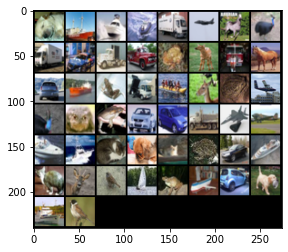

dog   ship  ship  ship  truck plane horse bird  truck car   truck truck frog  deer  truck horse car   ship  frog  truck ship  deer  frog  plane bird  frog  frog  car   car   truck plane plane ship  ship  cat   dog   cat   frog  car   ship  cat   deer  bird  ship  frog  plane car   dog   ship  bird 


In [34]:
def imshow(img):
    img = img   # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(loaders["train"])
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [35]:
images.shape

torch.Size([50, 3, 32, 32])

In [68]:
jitter = transforms.ColorJitter(brightness=.5, hue=.3)
jitted_imgs = jitter(images)

In [70]:
jitted_imgs.shape

torch.Size([50, 3, 32, 32])

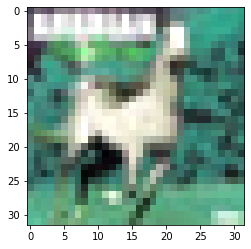

In [71]:
imshow(jitted_imgs[6,:,:,:])

In [65]:
rotimg = transforms.functional.rotate(images, 90)

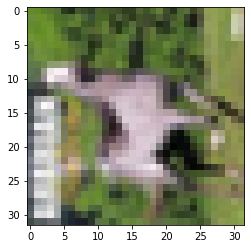

In [67]:
imshow(rotimg[6,:,:,:])

In [80]:
ex0 = images[9,:,:,:]

In [81]:
ex0d = torch.transpose(ex0.reshape(3,32*32), 1, 0)

In [82]:
kmeans = MiniBatchKMeans(n_clusters=2, random_state=0)

In [83]:
kmeans.fit(ex0d)

MiniBatchKMeans(n_clusters=2, random_state=0)

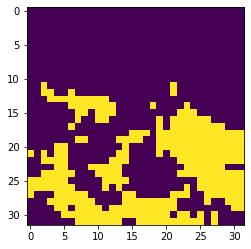

In [84]:
plt.imshow(kmeans.predict(ex0d).reshape(32,32))

In [17]:
class CNN5b(Module):   
    def __init__(self):
        super(CNN5b, self).__init__()
        
        self.conv1 = Sequential(
            Conv2d(3, 16, kernel_size=3, stride=1, padding=2),
            BatchNorm2d(16),
            ReLU(inplace=True),
            Dropout(0.15)
        )

        self.conv2 = Sequential(
            Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
            BatchNorm2d(32),
            ReLU(inplace=True),
            Dropout(0.15)
        )
        
        self.conv3 = Sequential(
            Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
            BatchNorm2d(64),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(0.25),
            Flatten()
        )
        
        self.dense1 = Sequential(
            Linear(23104, 32),
            Dropout(0.25)
        )
        
        self.dense2 = Sequential(
            Linear(32, 10)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

In [246]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN5b().to(device)
summary(model.to(device), (3, 32, 32))


In [21]:
len(loaders['train'])

1000

In [35]:
def train_nn(model, loaders, num_epochs, optimizer, penalty = "base", alpha = 0.1):
    constraints = {"base": StandardCrossEntropy()}
    model.train()
    total_step = len(loaders['train'])
    acc_x_epoch = []
    loss_x_batch = [] 
    loss_func = constraints[penalty]
    for epoch in range(num_epochs):
#        print('Memory Usage:')
#        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
                
        correct = 0
        for i, (images, labels) in enumerate(loaders['train']):
            images, labels = images.to(device), labels.to(device)
            b_x = Variable(images, requires_grad = True)    # batch x
            b_y = Variable(labels)   # batch y
            output = model(b_x)
#            grads = input_grads(output, b_x, b_y)
            loss = loss_func(output, b_y)
#            loss_x_batch.append(loss)
            flat_out = np.argmax(output.detach().cpu().numpy(), axis=1)
            correct += (flat_out == b_y.detach().cpu().numpy()).sum()
            optimizer.zero_grad()           
            loss.backward()    
            optimizer.step()
            
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                
                pass
            
            if (i + 1) == total_step:
                accuracy =  correct / (total_step*loaders['train'].batch_size)
                print('Accuracy = ', accuracy)
            
#            b_x = b_x.detach()
#            grads = grads.detach()
#            loss = loss.detach()
#            output = output.detach()
#            del output
#            del loss
#            del b_x
#            del grads
        
        acc_x_epoch.append(accuracy)
        
    
    return (acc_x_epoch, loss_x_batch)

In [23]:
criterion = StandardCrossEntropy()
optimizer = Adam(model.parameters(), lr=0.0005)  
acc, loss  = train_nn(model, loaders, 10, optimizer, penalty="base")

In [24]:
acc, loss  = train_nn(model, loaders, 10, optimizer, penalty="base")

Memory Usage:
Allocated: 0.0 GB


C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\losses\losses.py:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_probabilities = self.log_softmax(outputs)


Epoch [1/10], Step [100/1000], Loss: 2.1494
Epoch [1/10], Step [200/1000], Loss: 1.7083
Epoch [1/10], Step [300/1000], Loss: 1.6235
Epoch [1/10], Step [400/1000], Loss: 1.6976
Epoch [1/10], Step [500/1000], Loss: 1.8041
Epoch [1/10], Step [600/1000], Loss: 1.5830
Epoch [1/10], Step [700/1000], Loss: 1.7468
Epoch [1/10], Step [800/1000], Loss: 1.4717
Epoch [1/10], Step [900/1000], Loss: 1.4322
Epoch [1/10], Step [1000/1000], Loss: 1.5304
Accuracy =  0.38658
Memory Usage:
Allocated: 0.0 GB
Epoch [2/10], Step [100/1000], Loss: 1.1820
Epoch [2/10], Step [200/1000], Loss: 1.4551
Epoch [2/10], Step [300/1000], Loss: 1.4346
Epoch [2/10], Step [400/1000], Loss: 1.4375
Epoch [2/10], Step [500/1000], Loss: 1.2219
Epoch [2/10], Step [600/1000], Loss: 1.2572
Epoch [2/10], Step [700/1000], Loss: 1.5023
Epoch [2/10], Step [800/1000], Loss: 1.1394
Epoch [2/10], Step [900/1000], Loss: 1.0407
Epoch [2/10], Step [1000/1000], Loss: 1.2780
Accuracy =  0.53096
Memory Usage:
Allocated: 0.0 GB
Epoch [3/10], 

In [37]:
accuracy(symodel,loaders)

0.6361

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
loaders = MNIST_data(batch_size = 60, square_mask = True, size_min = 3, size_max=8)

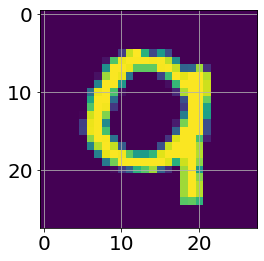

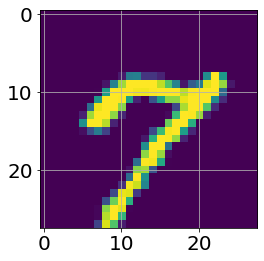

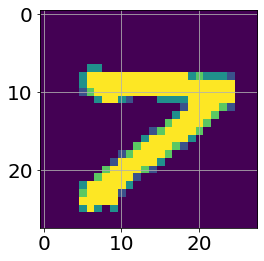

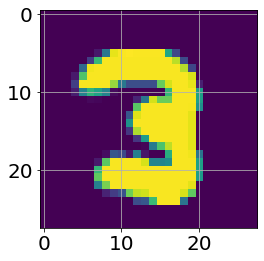

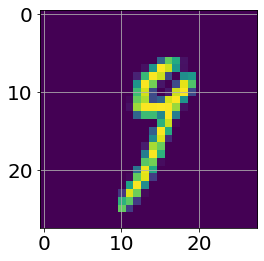

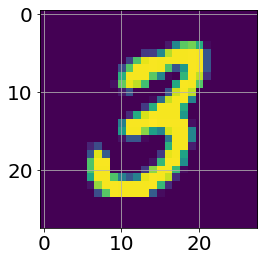

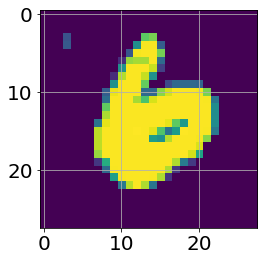

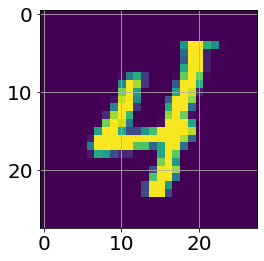

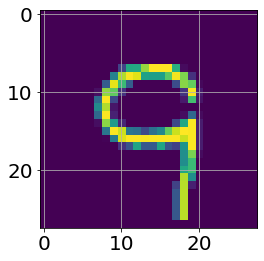

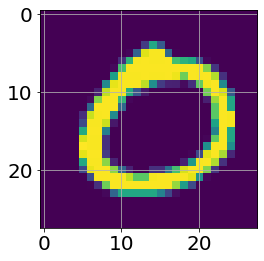

In [32]:
sample = iter(loaders['train'])
imgs = []
lbls = []


for i in range(10):
    img, lbl = next(sample)
    img = img.to(device)
    lbl = lbl.to(device)  
    plt.imshow(img[0,:,:].squeeze().cpu().numpy())
    plt.show()

In [3]:
import torch.nn.functional as F

In [7]:
F.pad(test_data.data[0,:,:], (1, 1, 1, 1))[:28,:28].shape

torch.Size([28, 28])

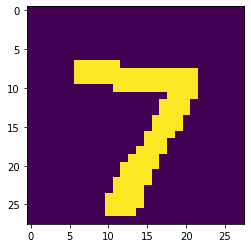

In [15]:
plt.imshow(test_data.data[0,:,:])

In [21]:
torch.roll(F.pad(test_data.data[0,:,:], (0, 0, 1, 1)),1,0).shape

torch.Size([30, 28])

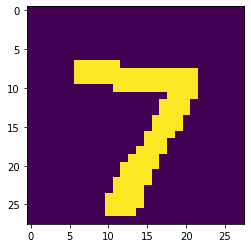

In [25]:
plt.imshow( test_data.data[0,:,:])

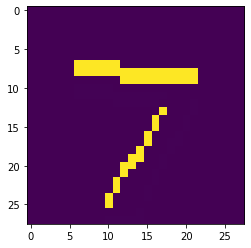

In [24]:
plt.imshow(torch.roll(F.pad(test_data.data[0,:,:], (0, 0, 1, 1)),1,0)[:28,:] - test_data.data[0,:,:])

In [12]:
test_data.data[0,:,:][test_data.data[0,:,:]>0] = 1

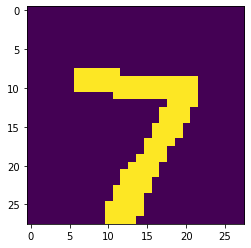

In [17]:
plt.imshow(torch.roll(test_data.data[0,:,:], 1, 0))

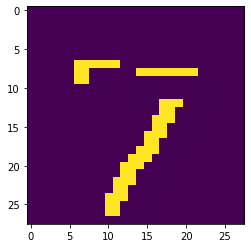

In [14]:
plt.imshow(torch.roll(F.pad(test_data.data[0,:,:], (1, 1, 1, 1)), 1, 1)[:28,:28]-test_data.data[0,:,:])

In [9]:
attr = grad.attribute(test_data.data.float().unsqueeze(1), target=test_data.targets)
q = [np.percentile(at[at!=0].flatten().numpy(), 10) for at in attr[:,0,:,:]]
maskpos = torch.ones((attr.shape))
for i in range(attr.shape[0]):
    maskpos[i,0,attr[i,0,:,:]>q[i]]=0
    test_data.data[i,:,:] = test_data.data[i,:,:]*maskpos[i,0,:,:]

In [10]:
loaders = {
        'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=60, 
                                          shuffle=True, 
                                          num_workers=1),
    
        'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=1, 
                                          shuffle=True, 
                                          num_workers=1),
}

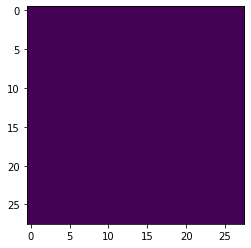

In [11]:
plt.imshow(train_data.data[0,:,:])

In [14]:
 torch.cuda.empty_cache()

In [15]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

NVIDIA GeForce RTX 2060 with Max-Q Design
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [6]:
smodel = CNN3b().to(device)
optimizer = Adam(smodel.parameters())   

In [7]:
acc, loss = train_gradreg(smodel, loaders, 8, optimizer, constraint="smoothness", alpha = 0.1)

C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\losses\losses.py:128: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_probabilities = self.log_softmax(outputs)


Epoch [1/8], Step [100/1000], Loss: 0.3655
Epoch [1/8], Step [200/1000], Loss: 0.2489
Epoch [1/8], Step [300/1000], Loss: 0.1628
Epoch [1/8], Step [400/1000], Loss: 0.0841
Epoch [1/8], Step [500/1000], Loss: 0.2008
Epoch [1/8], Step [600/1000], Loss: 0.0810
Epoch [1/8], Step [700/1000], Loss: 0.0445
Epoch [1/8], Step [800/1000], Loss: 0.0324
Epoch [1/8], Step [900/1000], Loss: 0.2146
Epoch [1/8], Step [1000/1000], Loss: 0.0518
Accuracy =  0.92375
Epoch [2/8], Step [100/1000], Loss: 0.0341
Epoch [2/8], Step [200/1000], Loss: 0.1097
Epoch [2/8], Step [300/1000], Loss: 0.0867
Epoch [2/8], Step [400/1000], Loss: 0.1028
Epoch [2/8], Step [500/1000], Loss: 0.0790
Epoch [2/8], Step [600/1000], Loss: 0.0582
Epoch [2/8], Step [700/1000], Loss: 0.2221
Epoch [2/8], Step [800/1000], Loss: 0.0536
Epoch [2/8], Step [900/1000], Loss: 0.0878
Epoch [2/8], Step [1000/1000], Loss: 0.1000
Accuracy =  0.97515
Epoch [3/8], Step [100/1000], Loss: 0.1122
Epoch [3/8], Step [200/1000], Loss: 0.1510
Epoch [3/8],

In [8]:
test_acc = accuracy(smodel,loaders)

In [9]:
print(test_acc)

0.9884


In [10]:
torch.save(smodel, r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\simple_cnn_smooth_"+str(test_acc)[2:]+".pt")

In [5]:
bmodel = torch.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\simple_cnn_9891.pt")
bmodel.eval()

CNN3b(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=784, out_features=10, bias=True)
)

In [4]:
smodel = torch.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\mnist_cnn_smoothness_9861.pt")
smodel.eval()

CNN3b(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=784, out_features=10, bias=True)
)

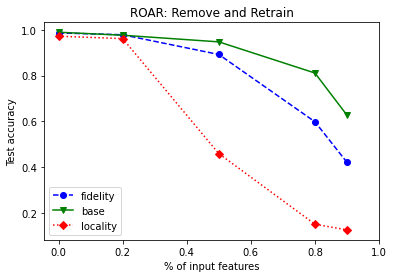

In [21]:
plt.title("ROAR: Remove and Retrain")
plt.plot([0, 0.2, 0.5, 0.8, 0.9], [0.986, 0.978, 0.892, 0.5982, 0.421], '--bo', label="fidelity")
plt.plot([0, 0.2, 0.5, 0.8, 0.9], [0.989, 0.976, 0.947, 0.811, 0.627], '-gv', label="base")
plt.plot([0, 0.2, 0.5, 0.8, 0.9], [0.9717, 0.9612, 0.4592, 0.1509, 0.126], ':rD', label="locality")
plt.legend()
plt.xticks(np.linspace(0, 1, 6))
plt.ylabel("Test accuracy")
plt.xlabel("% of input features")
plt.savefig(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\ROAR_curve_fid_base.png")
plt.show()

In [18]:
accuracy(bmodel_roar,loaders)

0.9754

In [19]:
torch.save(bmodel_roar, r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\roar_base_9754.pt")

In [10]:
accuracy(gmodel,loaders)

0.9871

In [11]:
torch.save(gmodel, r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\3b_cnn_adam_gen_9871.pt")

In [8]:
accuracy(fmodel,loaders)

0.9894

In [19]:
accuracy(bmodel,loaders)

0.9906

In [13]:
accuracy(gmodel,loaders)

0.9877

In [19]:
accuracy(bmodel1,loaders)

0.9881

In [20]:
#torch.save(bmodel1, r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\4b_cnn_adadelta_9881.pt")

In [9]:
x = []
y = []

for images, labels in loaders['train']:
    x.append(images)
    y.append(labels)

In [10]:
x[0].shape

torch.Size([60, 1, 28, 28])

In [15]:
torch.argmax(Softmax()(model1(x[0].to(device))), dim=1)

C:\Users\unknown\Anaconda3\envs\xai4uc3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([1, 8, 8, 9, 7, 4, 6, 9, 0, 0, 0, 7, 0, 5, 7, 4, 3, 3, 3, 3, 6, 2, 7, 1,
        2, 6, 6, 9, 3, 4, 6, 5, 9, 6, 0, 3, 9, 4, 4, 1, 8, 5, 6, 1, 5, 2, 2, 9,
        8, 6, 7, 1, 4, 0, 9, 7, 6, 0, 4, 1], device='cuda:0')

In [7]:
drop1 = MoRF(bmodel, loaders, perc, method="lrp")

C:\Users\unknown\Anaconda3\envs\xai4uc3\lib\site-packages\captum\_utils\gradient.py:58: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\metrics\metrics.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  d = softm(model(images.cuda()*maskpos.cuda())).cpu().detach().numpy()[0,torch.argmax(softm(model(images.cuda())))]/torch.max(softm(model(images.cuda()))).cpu().detach().numpy()


In [8]:
1-drop1

array([0.        , 0.15505386, 0.35326039, 0.55876377, 0.73631137,
       0.82415495, 0.87631242, 0.90790351, 0.93100283, 0.94241055,
       0.95066297, 0.95559538, 0.95936436, 0.96079871, 0.9627737 ,
       0.96374527, 0.96278833, 0.95849832, 0.94877445, 0.91177031])

In [251]:
drop1 = MoRF(symodel, loaders, perc)

In [26]:
drop2 = MoRF(fmodel, loaders, perc)

C:\Users\unknown\Anaconda3\envs\xai4uc3\lib\site-packages\captum\_utils\gradient.py:58: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\metrics\metrics.py:60: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  d = softm(model(images.cuda()*maskpos.cuda())).cpu().detach().numpy()[0,torch.argmax(softm(model(images.cuda())))]/torch.max(softm(model(images.cuda()))).cpu().detach().numpy()


In [9]:
1-drop0

array([0.        , 0.15804938, 0.3613576 , 0.56179799, 0.7367757 ,
       0.82593995, 0.87778318, 0.90810521, 0.93072178, 0.94199983,
       0.94888471, 0.95374279, 0.95751858, 0.9595974 , 0.96063658,
       0.96104276, 0.96068986, 0.95787975, 0.94806626, 0.91151322])

In [10]:
dropb = np.array([0.        , 0.1794248 , 0.35596219, 0.48851629, 0.59892082,
       0.65963836, 0.70038042, 0.73215046, 0.76136257, 0.78141486,
       0.79677954, 0.81130123, 0.82805767, 0.83918243, 0.85129128,
       0.86347635, 0.87639529, 0.88582325, 0.89485204, 0.8985666 ])

In [252]:
1-drop0

array([0.        , 0.1794248 , 0.35596219, 0.48851629, 0.59892082,
       0.65963836, 0.70038042, 0.73215046, 0.76136257, 0.78141486,
       0.79677954, 0.81130123, 0.82805767, 0.83918243, 0.85129128,
       0.86347635, 0.87639529, 0.88582325, 0.89485204, 0.8985666 ])

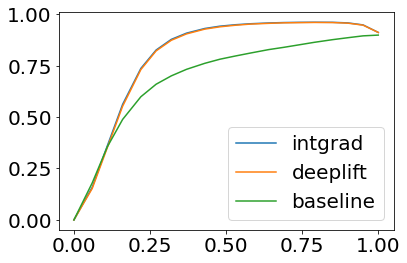

In [14]:
plt.plot(1-np.array(perc)/100, 1-drop0, label="intgrad")
plt.plot(1-np.array(perc)/100, 1-drop1, label="deeplift")
plt.plot(1-np.array(perc)/100, dropb, label="baseline")
plt.legend()
plt.show()

In [4]:
test_data = datasets.MNIST(
        root = 'data', 
        train = False, 
        transform = transforms.Compose([transforms.ToTensor(),
                                                  AddSquareMask(6)])
        )

In [5]:
loadr =  torch.utils.data.DataLoader(test_data, 
                                          batch_size=1, 
                                          shuffle=True, 
                                          num_workers=0)

size =  torch.Size([1, 28, 28])
6


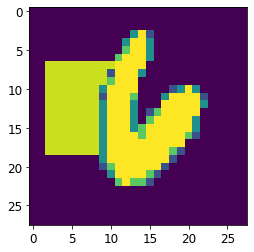

size =  torch.Size([1, 28, 28])
8


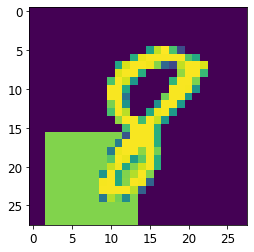

size =  torch.Size([1, 28, 28])
8


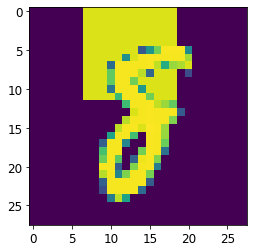

size =  torch.Size([1, 28, 28])
2


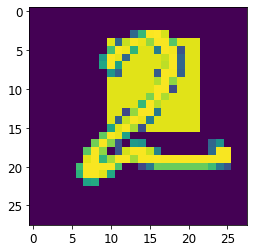

size =  torch.Size([1, 28, 28])
3


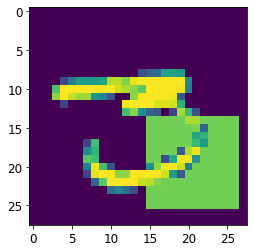

size =  torch.Size([1, 28, 28])
5


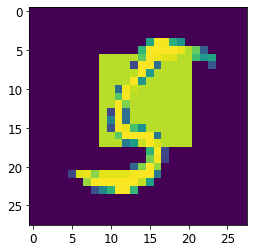

size =  torch.Size([1, 28, 28])
1


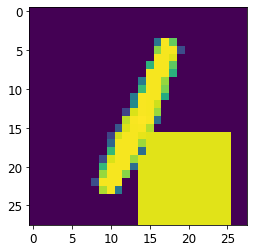

size =  torch.Size([1, 28, 28])
4


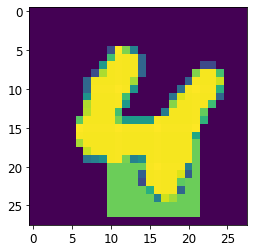

size =  torch.Size([1, 28, 28])
0


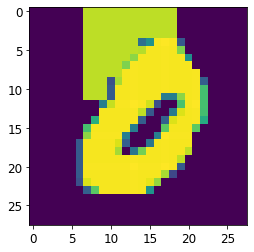

size =  torch.Size([1, 28, 28])
9


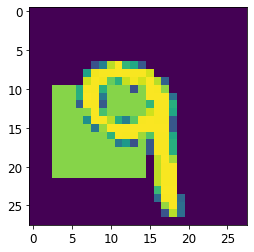

size =  torch.Size([1, 28, 28])
2


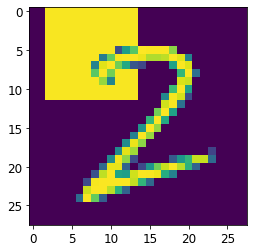

size =  torch.Size([1, 28, 28])
6


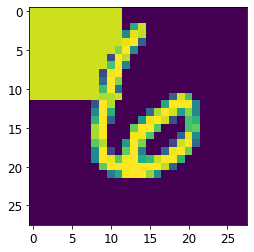

size =  torch.Size([1, 28, 28])
4


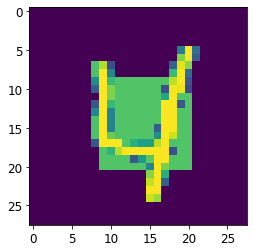

size =  torch.Size([1, 28, 28])
4


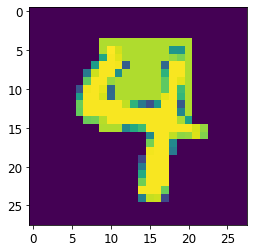

size =  torch.Size([1, 28, 28])
7


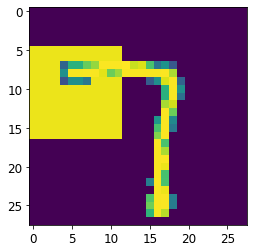

size =  torch.Size([1, 28, 28])
3


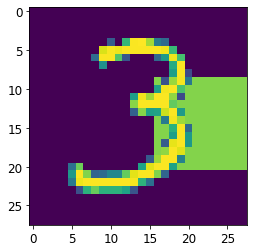

size =  torch.Size([1, 28, 28])
5


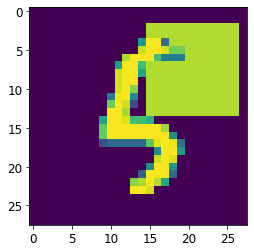

size =  torch.Size([1, 28, 28])
2


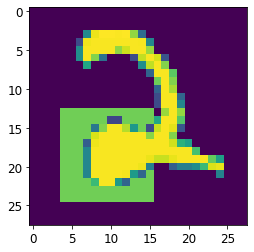

size =  torch.Size([1, 28, 28])
0


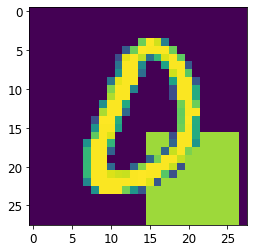

size =  torch.Size([1, 28, 28])
0


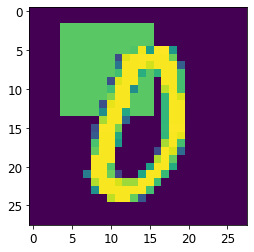

size =  torch.Size([1, 28, 28])
9


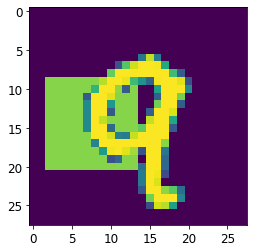

size =  torch.Size([1, 28, 28])
0


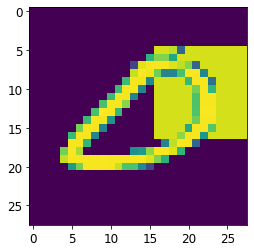

size =  torch.Size([1, 28, 28])
6


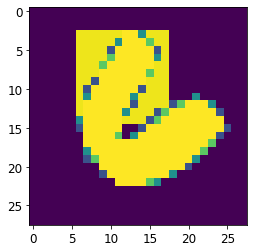

size =  torch.Size([1, 28, 28])
9


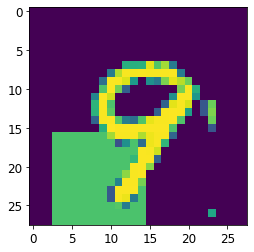

size =  torch.Size([1, 28, 28])
5


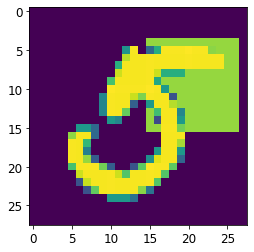

size =  torch.Size([1, 28, 28])
8


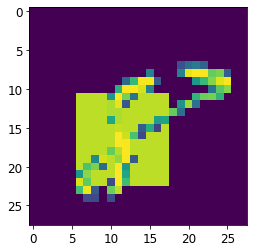

size =  torch.Size([1, 28, 28])
0


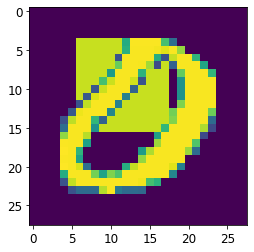

size =  torch.Size([1, 28, 28])
5


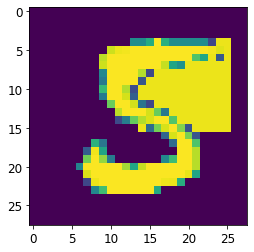

size =  torch.Size([1, 28, 28])
5


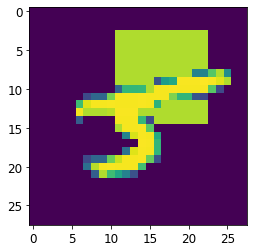

size =  torch.Size([1, 28, 28])
1


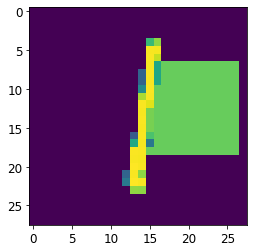

size =  torch.Size([1, 28, 28])
8


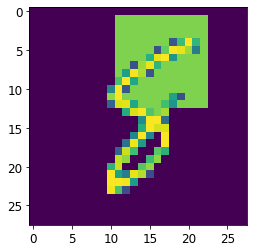

size =  torch.Size([1, 28, 28])
3


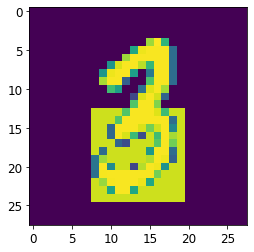

size =  torch.Size([1, 28, 28])
7


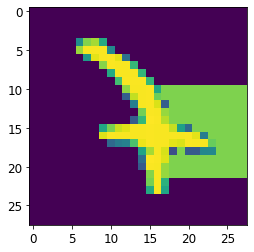

size =  torch.Size([1, 28, 28])
9


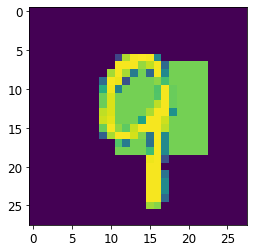

size =  torch.Size([1, 28, 28])
4


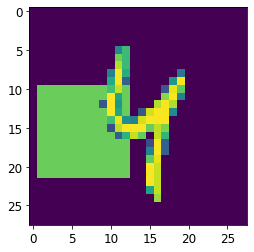

size =  torch.Size([1, 28, 28])
5


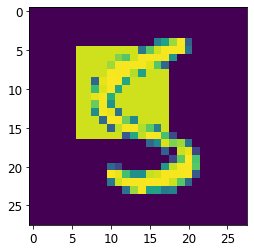

size =  torch.Size([1, 28, 28])
7


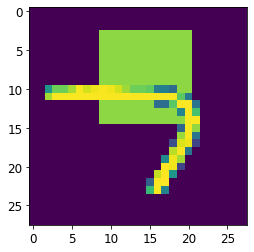

size =  torch.Size([1, 28, 28])
5


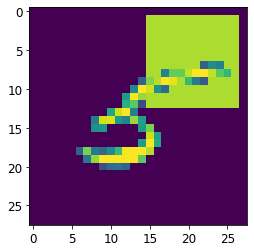

size =  torch.Size([1, 28, 28])
0


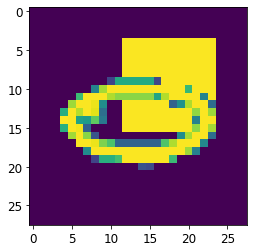

size =  torch.Size([1, 28, 28])
6


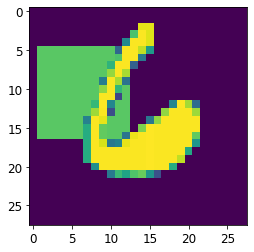

size =  torch.Size([1, 28, 28])
9


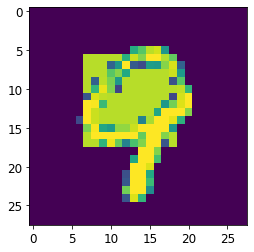

size =  torch.Size([1, 28, 28])
5


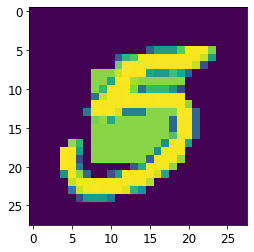

size =  torch.Size([1, 28, 28])
0


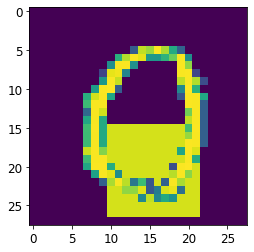

size =  torch.Size([1, 28, 28])
0


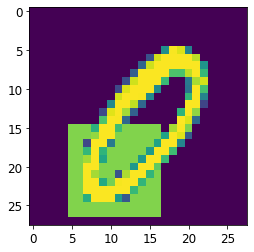

size =  torch.Size([1, 28, 28])
0


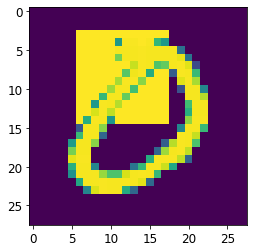

size =  torch.Size([1, 28, 28])
6


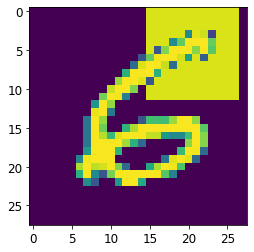

size =  torch.Size([1, 28, 28])
4


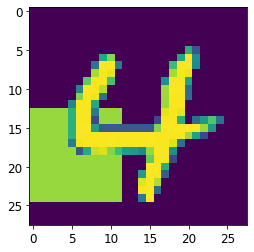

size =  torch.Size([1, 28, 28])
9


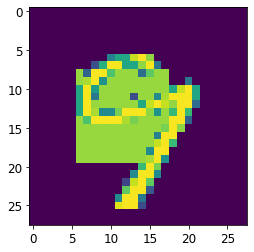

size =  torch.Size([1, 28, 28])
2


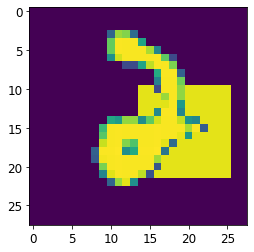

size =  torch.Size([1, 28, 28])
9


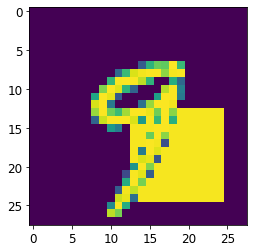

size =  torch.Size([1, 28, 28])
6


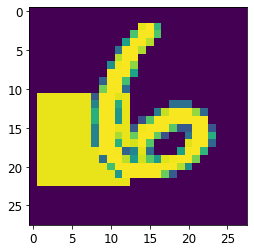

size =  torch.Size([1, 28, 28])
2


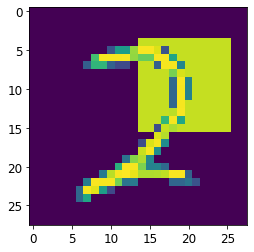

size =  torch.Size([1, 28, 28])
4


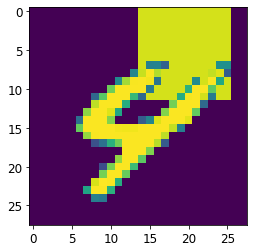

size =  torch.Size([1, 28, 28])
7


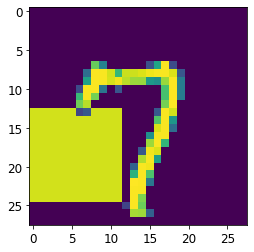

size =  torch.Size([1, 28, 28])
5


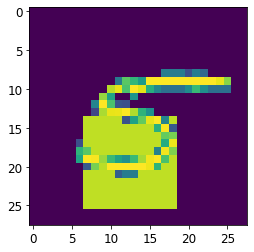

size =  torch.Size([1, 28, 28])
6


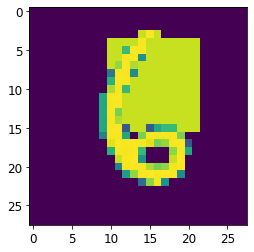

size =  torch.Size([1, 28, 28])
2


KeyboardInterrupt: 

In [6]:
for images, labels in loadr:
    plt.imshow(images.squeeze())
    print(labels.item())
    plt.show()

In [47]:
test_data.data.shape

torch.Size([10000, 28, 28])

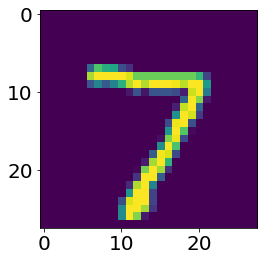

In [48]:
plt.imshow(test_data.data[0,:,:])

In [32]:
loadr =  torch.utils.data.DataLoader(test_data, 
                                          batch_size=1, 
                                          shuffle=True, 
                                          num_workers=1)

In [34]:
x = []
y = []

for images, labels in loadr:
    x.append(images)
    y.append(labels)

In [38]:
y[1]

tensor([7])

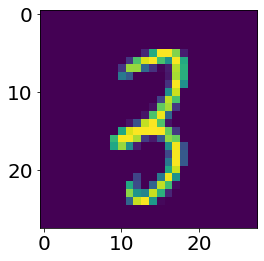

In [45]:
plt.imshow(x[15].squeeze())

In [253]:
1-drop1

array([0.        , 0.02149336, 0.08026218, 0.16558667, 0.29903241,
       0.4110081 , 0.50776571, 0.5851186 , 0.66073924, 0.70995666,
       0.75038237, 0.78355312, 0.81191606, 0.83160382, 0.84796216,
       0.86167952, 0.87519915, 0.88519554, 0.8935347 , 0.89840146])

In [254]:
print('computed AUC using sklearn.metrics.auc: {}'.format(auc(1-np.array(perc)/100, 1-drop0)))


computed AUC using sklearn.metrics.auc: 0.6984086843472173


In [255]:
print('computed AUC using sklearn.metrics.auc: {}'.format(auc(1-np.array(perc)/100, 1-drop1)))


computed AUC using sklearn.metrics.auc: 0.5968810944847851


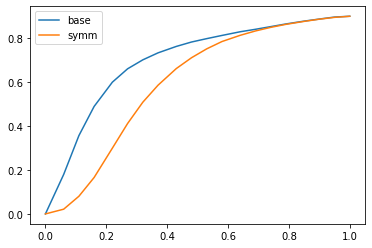

In [256]:
plt.plot(1-np.array(perc)/100, 1-drop0, label="base")
plt.plot(1-np.array(perc)/100, 1-drop1, label="symm")
plt.legend()
plt.show()

In [30]:
print('computed AUC using sklearn.metrics.auc: {}'.format(auc(1-np.array(perc)/100, 1-drop2)))


computed AUC using sklearn.metrics.auc: 0.8486846666890016


In [32]:
print('computed AUC using sklearn.metrics.auc: {}'.format(auc(1-np.array(perc)/100, 1-drop3)))


computed AUC using sklearn.metrics.auc: 0.7680681740703059


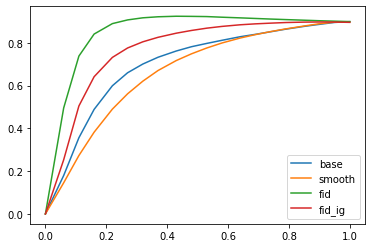

In [34]:
plt.plot(1-np.array(perc)/100, 1-drop0, label="base")
plt.plot(1-np.array(perc)/100, 1-drop1, label="smooth")
plt.plot(1-np.array(perc)/100, 1-drop2, label="fid")
plt.plot(1-np.array(perc)/100, 1-drop3, label="fid_ig")
plt.legend()
plt.show()

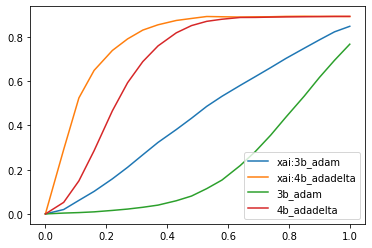

In [33]:
plt.title("MoRF curve")
plt.plot(1-np.array(perc)/100, 1-drop0, label="xai:3b_adam")
plt.plot(1-np.array(perc)/100, 1-drop1, label="xai:4b_adadelta")
plt.plot(1-np.array(perc)/100, 1-bdrop0, label="3b_adam")
plt.plot(1-np.array(perc)/100, 1-bdrop1, label="4b_adadelta")
plt.xlabel("% pix removed")
plt.ylabel("avg error")
plt.legend()
plt.savefig(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\MoRF_curve_fidelity_3b4b.png")
plt.show()

In [38]:
np.mean(1-drop0)

0.4373033463348592

In [39]:
np.mean(1-drop1)

0.7678295304900484

In [40]:
np.mean(1-bdrop1)

0.6769576146917377

In [41]:
np.mean(1-bdrop0)

0.2219057289009787